# Image classification

## Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
print(tf.__version__)

2.6.0


### Get the dataset

In [3]:
training_dir = '../dataset/training'
validation_dir = '../dataset/validation'
test_dir = '../dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

In [4]:
training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                               shuffle=True,
                                                               label_mode='categorical',
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 13140 files belonging to 6 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2580 files belonging to 6 classes.


### Explore the training dataset

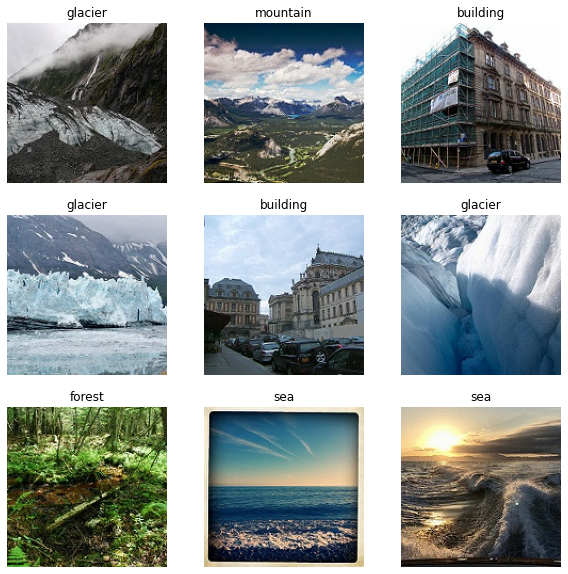

In [6]:
class_names = training_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

### Data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

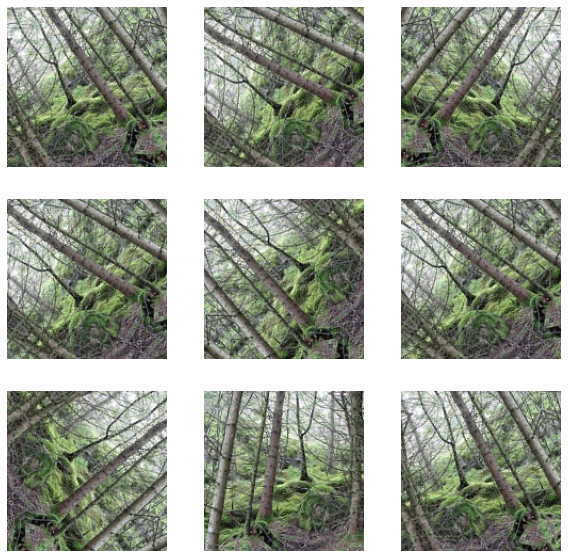

In [8]:
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model Development And Training

### Rescale pixel values

We will use `tf.keras.applications.MobileNetV2` as our base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Creation of the base model using a CNN architecture

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 75, 75, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [13]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

In [14]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model (Feature extraction)

In [15]:
from tensorflow.keras.optimizers import Adam

base_learning_rate = 0.0001

opt = Adam(learning_rate=base_learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 150, 150, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [17]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

81/81 [==============================] - 15s 169ms/step - loss: 2.3159 - accuracy: 0.1516
initial loss: 2.32
initial accuracy: 0.15


### Model training

In [18]:
history = model.fit(training_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
411/411 [==============================] - 108s 256ms/step - loss: 1.2497 - accuracy: 0.5205 - val_loss: 0.6945 - val_accuracy: 0.7504
Epoch 2/10
411/411 [==============================] - 108s 262ms/step - loss: 0.6650 - accuracy: 0.7502 - val_loss: 0.4977 - val_accuracy: 0.8248
Epoch 3/10
411/411 [==============================] - 108s 264ms/step - loss: 0.5388 - accuracy: 0.7997 - val_loss: 0.4259 - val_accuracy: 0.8465
Epoch 4/10
411/411 [==============================] - 104s 253ms/step - loss: 0.4887 - accuracy: 0.8192 - val_loss: 0.3938 - val_accuracy: 0.8605
Epoch 5/10
411/411 [==============================] - 104s 254ms/step - loss: 0.4759 - accuracy: 0.8238 - val_loss: 0.3775 - val_accuracy: 0.8678
Epoch 6/10
411/411 [==============================] - 107s 261ms/step - loss: 0.4424 - accuracy: 0.8404 - val_loss: 0.3574 - val_accuracy: 0.8764
Epoch 7/10
411/411 [==============================] - 107s 261ms/step - loss: 0.4286 - accuracy: 0.8453 - val_loss: 0.3430 -

In [19]:
base_model.trainable = True

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Recompile the model (Fine tuning)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 150, 150, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

### Continue training and save the model

In [22]:
fine_tuning_epochs = 10

total_epochs =  initial_epochs + fine_tuning_epochs

model.fit(training_dataset,
          epochs=total_epochs,
          initial_epoch=history.epoch[-1],
          validation_data=validation_dataset)

Epoch 10/20
411/411 [==============================] - 160s 378ms/step - loss: 0.3791 - accuracy: 0.8646 - val_loss: 0.2950 - val_accuracy: 0.8907
Epoch 11/20
411/411 [==============================] - 154s 375ms/step - loss: 0.3382 - accuracy: 0.8757 - val_loss: 0.2816 - val_accuracy: 0.8953
Epoch 12/20
411/411 [==============================] - 157s 382ms/step - loss: 0.3002 - accuracy: 0.8908 - val_loss: 0.2623 - val_accuracy: 0.9008
Epoch 13/20
411/411 [==============================] - 154s 375ms/step - loss: 0.2849 - accuracy: 0.8968 - val_loss: 0.2287 - val_accuracy: 0.9143
Epoch 14/20
411/411 [==============================] - 153s 373ms/step - loss: 0.2745 - accuracy: 0.9013 - val_loss: 0.2318 - val_accuracy: 0.9140
Epoch 15/20
411/411 [==============================] - 155s 376ms/step - loss: 0.2550 - accuracy: 0.9082 - val_loss: 0.2331 - val_accuracy: 0.9136
Epoch 16/20
411/411 [==============================] - 153s 373ms/step - loss: 0.2416 - accuracy: 0.9116 - val_loss: 0

In [23]:
model.save('../models/img_classif_model')

INFO:tensorflow:Assets written to: ../models/img_classif_model\assets


## Prediction On New Data

In [24]:
import pathlib

dataset_dir = pathlib.Path('../dataset')
dataset_test_dir = list(dataset_dir.glob('test/*'))

### Showing details of confidence for each prediction

In [25]:
for i in range(9):
    path_to_file = str(dataset_test_dir[i])
    img = tf.keras.utils.load_img(path_to_file, target_size=IMG_SHAPE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = predictions[0]
    print("This image most likely belongs to {} with a {:.2f} percent confidence."
          .format(class_names[np.argmax(score)], 100 * np.max(score)))

This image most likely belongs to mountain with a 98.23 percent confidence.
This image most likely belongs to sea with a 99.99 percent confidence.
This image most likely belongs to mountain with a 99.28 percent confidence.
This image most likely belongs to forest with a 99.44 percent confidence.
This image most likely belongs to mountain with a 84.70 percent confidence.
This image most likely belongs to glacier with a 98.17 percent confidence.
This image most likely belongs to building with a 99.96 percent confidence.
This image most likely belongs to forest with a 99.82 percent confidence.
This image most likely belongs to building with a 66.98 percent confidence.


### Showing graphical details for each prediction

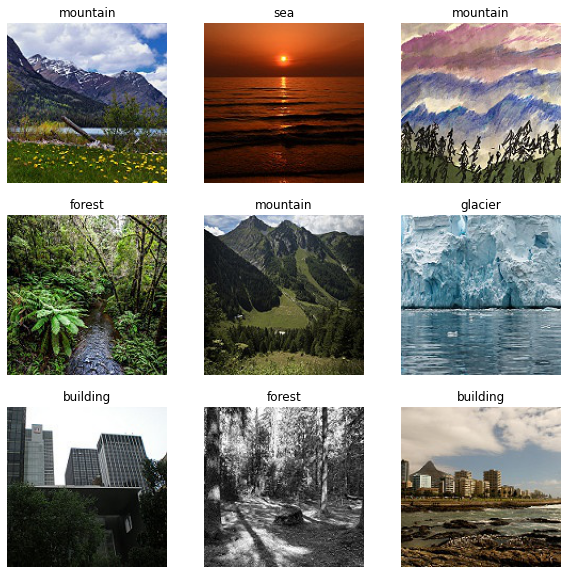

In [26]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  path_to_file = str(dataset_test_dir[i])
  img = tf.keras.utils.load_img(path_to_file, target_size=IMG_SHAPE)
  img_array = tf.keras.utils.img_to_array(img)
  plt.imshow(img_array.astype("uint8"))
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)
  score = predictions[0]
  plt.title(class_names[np.argmax(score)])
  plt.axis("off")